# Wstęp do sieci neuronowych


<img src="figures/L9/cat_neuron.jpg" width=500>

Ref: 

* http://cs231n.github.io/optimization-1/ 

* https://github.com/leriomaggio/deep-learning-keras-tensorflow/blob/master/1.3%20Introduction%20-%20Keras.ipynb

* http://colah.github.io/posts/2014-10-Visualizing-MNIST/

* https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/neural_net_implementation/neural_network_implementation_part02.ipynb


Na dzisiejszych zajęciach omówimy jak można zaimplementować jako sieć neuronową znany nam model regresji logistycznej, najpierw bardziej ręcznie, a następnie z użyciem pakietu keras. Omówimy na końcu spojrzenie na sieci neuronowe z perspektywy uczenia reprezentacji.

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.decomposition import RandomizedPCA
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
from matplotlib.colors import colorConverter, ListedColormap
from matplotlib import cm #
import os
import tqdm
os.environ['KERAS_BACKEND'] = 'theano'
import keras
from keras.datasets import mnist
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
%matplotlib inline
np.random.seed(seed=1)

Using Theano backend.
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Small MNIST 
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
sm_train = mnist_x_train[0:500].astype('float32') / 255.
sm_y_train = mnist_y_train[0:500]
sm_test = mnist_x_test[0:500].astype('float32') / 255.
sm_y_test = mnist_y_test[0:500]
sm_train = sm_train.reshape((len(sm_train), np.prod(sm_train.shape[1:])))
sm_test = sm_test.reshape((len(sm_test), np.prod(sm_test.shape[1:])))
print sm_train.shape
print sm_test.shape

(500, 784)
(500, 784)


In [3]:
if not keras.__version__[0] == '2':
    raise Exception("Prosze zainstalowac keras>=2.0.0")

In [4]:
def logistic(z): 
    return 1 / (1 + np.exp(-z))

def nn(x, w): 
    return logistic(x.dot(w.T))

def nn_predict(x,w): 
    return np.array(np.around(nn(x,w)))

def cost(y, t):
    return - np.sum(np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

In [5]:
# Define and generate the samples
nb_of_samples_per_class = 100  # The number of sample in each class
red_mean = [-1,0]  # The mean of the red class
blue_mean = [1,0]  # The mean of the blue class
std_dev = 1.2  # standard deviation of both classes
# Generate samples from both classes
x_red = np.random.randn(nb_of_samples_per_class, 2) * std_dev + red_mean
x_blue = np.random.randn(nb_of_samples_per_class, 2) * std_dev + blue_mean

# Merge samples in set of input variables x, and corresponding set of output variables t
X_toy = np.vstack((x_red, x_blue))
t_toy = np.vstack((np.zeros((nb_of_samples_per_class,1)), np.ones((nb_of_samples_per_class,1))))

toy_train, toy_test, toy_y_train, toy_y_test = train_test_split(X_toy, t_toy, test_size=0.15)

# Przyda sie do sekcji o kerasie
toy_y_train_one_hot = keras.utils.to_categorical(toy_y_train)
toy_y_test_one_hot = keras.utils.to_categorical(toy_y_test)

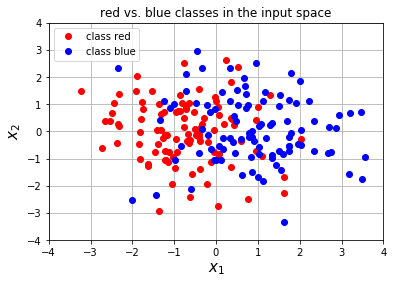

In [23]:

# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='class red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-4, 4, -4, 4])
plt.title('red vs. blue classes in the input space')
plt.show()

# Siec Neuronowa, a regresja logistyczna

Przypomnijmy sobie co robi regresja logistyczna. Z L7:

Przekształcając $$ \log(o) = \sum \theta_i x_i $$ otrzymujemy *bezpośrednio*, że $$ p(y | x) = \mbox{sigmoid}(\sum \theta_i x_i) $$, gdzie $sigmoid(a) = \frac{1}{1 + \exp(-a)}$.

Można ostatni wzór zapisać w postaci "sieci neuronowej":

<center><img width=500 src="figures/L9/logreg.png"></center>

To co pozostaje to jak wyznaczyć wagi przez optymalizacją. Przypomnijmy, że szukamy parametrów optymalizujących log-likelihood $$ LL(\hat y, y) = CE(\hat y, y) = \sum_{i=1}^{N} y \log\hat(y) $$. W regresji liniowej było prosto!

[Opisać/wyjaśnic cross entropy]

## Czego szuka regresja logistyczna

Regresja logistyczna dostaje kare za najdrobniejsza pomyłkę. Jeśli dla kasy 1 mówi z pewnością 99%, to dalej będzie niezerowy koszt:
    
<img width=500 src="figures/L9/logreg_vs_svm.png">

## Optymalizacja

Jak dotad nie rozpatrywaliśmy optymalizacji. Regresja liniowa ma rozwiązanie "zamknięte", ale nie wiemy jak optymalizować błąd regresji logistycznej!

$$ \theta^* = argmax_{\theta} L(p( \hat y | x, \theta), y) = CE(p(\hat y | x, \theta), y) = \sum_{i=1}^{N} y \log\hat(y) $$.

Dla klas binarnych:

$$ \sum_{i=1}^N y_i \log \hat y_i - (1 - y_i) \log (1 - \hat y_i ) $$

Jak znaleźć $\theta^*$? Użyjemy metody gradientowej:

$$ \theta^{t+1} = \theta^{t} - \alpha \frac{\partial L}{\partial \theta} $$

### Funkcja kosztu nie jest już taka prosta!

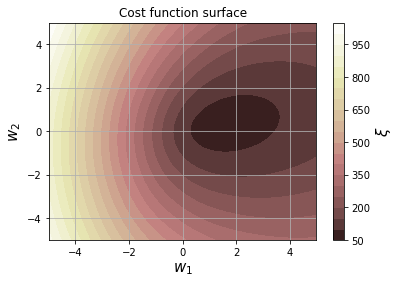

In [120]:
# Plot the cost in function of the weights
# Define a vector of weights for which we want to plot the cost
nb_of_ws = 100 # compute the cost nb_of_ws times in each dimension
ws1 = np.linspace(-5, 5, num=nb_of_ws) # weight 1
ws2 = np.linspace(-5, 5, num=nb_of_ws) # weight 2
ws_x, ws_y = np.meshgrid(ws1, ws2) # generate grid
cost_ws = np.zeros((nb_of_ws, nb_of_ws)) # initialize cost matrix

# Fill the cost matrix for each combination of weights
for i in range(nb_of_ws):
    for j in range(nb_of_ws):
        cost_ws[i,j] = cost(nn(toy_train, np.asmatrix([ws_x[i,j], ws_y[i,j]])) , toy_y_train)
        
# Plot the cost function surface
plt.contourf(ws_x, ws_y, cost_ws, 20, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('$\\xi$', fontsize=15)
plt.xlabel('$w_1$', fontsize=15)
plt.ylabel('$w_2$', fontsize=15)
plt.title('Cost function surface')
plt.grid()
plt.show()

### Implementacja SGD

[Wyprowadzić na tablicy wzór na dLL/dtheta_i, jak to sie ma do backprop]

Jak właśnie pokazaliśmy $$ \frac{\partial L}{\partial \theta_i} = x_i (\hat y_i - t_i) $$

[Interpretacja geometryczna gradientu regresji logistycznej]

### Zadanie 1, Nauka regresji logistycznej przez GD [2pkt]

(Uwaga: jest GD nie SGD ponieważ liczymy gradient na całym zbiorze)

1. Zaimplementuj GD dla zbioru danych toy. 
2. Wygeneruj wizualizacje procesu uczenia (ostatnia komórka)
3. Narysuj wizualizacje dla learning_rate=10.0, 5.0, 2.5, 1.0
4. Dla jakiego learning_rate osiągamy najlepszą dokladnosc na (toy_test, toy_y_test)?

Co powinno wyjść dla odpowiednio 5.0 oraz 2.5

<img width=200 src="figures/L9/lr5.png">
<img width=200 src="figures/L9/lr2.5.png">

Uwaga: Należy uśredniać gradient w funkcji "gradient", dziękujemy za zauważenie błędu Krzysztofowi Paskowi.

In [121]:
def gradient(w, x, t): 
    ret = np.dot(x.T, (logistic(np.dot(x, w.T)) - t)) / x.shape[0]
    return ret

def delta_w(w_k, x, t, learning_rate):
    return (learning_rate * gradient(w_k, x, t)).T

def gd_learn(learning_rate):

    # Parametry uczenia 
    w = np.asmatrix([-4, -2])

    # Uczenie
    nb_of_iterations = 10
    w_iter = [w] 
    for i in range(nb_of_iterations):
        dw = delta_w(w, toy_train, toy_y_train, learning_rate) 
        w = w - dw 
        w_iter.append(w)  
        
    return w_iter

In [122]:
# Plot the first weight updates on the error surface
# Plot the error surface
def plot_wight_updates(w_iter):
    plt.contourf(ws_x, ws_y, cost_ws, 20, alpha=0.9, cmap=cm.pink)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('cost')

    # Plot the updates
    for i in range(1, 4): 
        w1 = w_iter[i-1]
        w2 = w_iter[i]
        # Plot the weight-cost value and the line that represents the update
        plt.plot(w1[0,0], w1[0,1], 'bo')  # Plot the weight cost value
        plt.plot([w1[0,0], w2[0,0]], [w1[0,1], w2[0,1]], 'b-')
        plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(i), color='b')
    w1 = w_iter[3]  
    # Plot the last weight
    plt.plot(w1[0,0], w1[0,1], 'bo')
    plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(4), color='b') 
    # Show figure
    plt.xlabel('$w_1$', fontsize=15)
    plt.ylabel('$w_2$', fontsize=15)
    plt.title('Gradient descent updates on cost surface')
    plt.grid()
    plt.show()

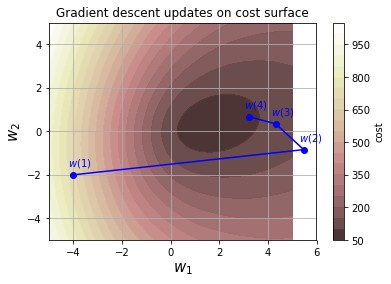

L. rate:  10.0  score:  0.7


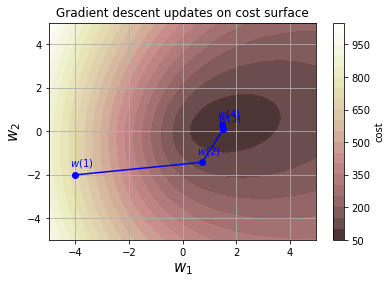

L. rate:  5.0  score:  0.7


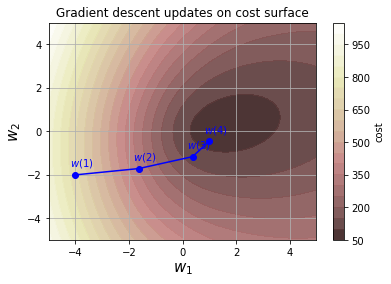

L. rate:  2.5  score:  0.7


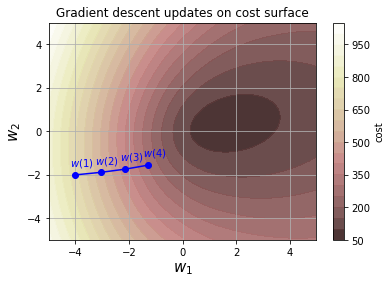

L. rate:  1.0  score:  0.733333333333


In [141]:
from sklearn.metrics import accuracy_score

for learning_rate in [10.0, 5.0, 2.5, 1.0]:
    w_iter = gd_learn(learning_rate)
    plot_wight_updates(w_iter)
    
    print "L. rate: ", learning_rate, " score: ", accuracy_score(toy_y_test, logistic(np.dot(toy_test, w_iter[-1].T)) > 0.5)

# keras

Sieci neuronowe definiujemy prawie tak prosto jak funkcje w Pythonie, a pochodne (to co liczyłem na tablicy) powinien nam liczyć komputer!

In [313]:
dims = toy_train.shape[1]
print(dims, 'dims')
nb_classes = toy_y_train_one_hot.shape[1]
print(nb_classes, 'classes')

(2, 'dims')
(2, 'classes')


In [318]:
# 1. Definicja modelu

model = Sequential()
model.add(Dense(1000, input_shape=(dims, ), init='uniform'))
model.add(Dense(nb_classes, input_shape=(1000,)))
model.add(Activation('sigmoid'))

# 2. Kompilacja
model.compile(optimizer=SGD(lr=.01), loss='binary_crossentropy', metrics=['accuracy'])

batch = 70

# 3. Uczenie
model.fit(toy_train, toy_y_train_one_hot, epochs=10, batch_size=batch)

# 4. Predykcja
toy_y_pred = model.predict(toy_test, batch_size=batch).argmax(axis=1)
toy_y_train_pred = model.predict(toy_train, batch_size=batch).argmax(axis=1)
print model.layers[0].trainable_weights[0].get_value()
print np.mean(toy_y_train.reshape(-1,) == toy_y_train_pred)
print np.mean(toy_y_test.reshape(-1,) == toy_y_pred)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="uniform", input_shape=(2,))`
  after removing the cwd from sys.path.


Epoch 1/10
170/170 [==============================] - ETA: 0s - loss: 0.7007 - acc: 0.371 - 0s - loss: 0.6974 - acc: 0.4382     
Epoch 2/10
170/170 [==============================] - ETA: 0s - loss: 0.6881 - acc: 0.585 - 0s - loss: 0.6854 - acc: 0.5971     
Epoch 3/10
170/170 [==============================] - ETA: 0s - loss: 0.6772 - acc: 0.671 - 0s - loss: 0.6744 - acc: 0.7000     
Epoch 4/10
170/170 [==============================] - ETA: 0s - loss: 0.6660 - acc: 0.700 - 0s - loss: 0.6641 - acc: 0.7265     
Epoch 5/10
170/170 [==============================] - ETA: 0s - loss: 0.6560 - acc: 0.742 - 0s - loss: 0.6538 - acc: 0.7529     
Epoch 6/10
170/170 [==============================] - ETA: 0s - loss: 0.6441 - acc: 0.792 - 0s - loss: 0.6447 - acc: 0.7824     
Epoch 7/10
170/170 [==============================] - ETA: 0s - loss: 0.6378 - acc: 0.800 - 0s - loss: 0.6354 - acc: 0.7971     
Epoch 8/10
170/170 [==============================] - ETA: 0s - loss: 0.6333 - acc: 0.742 - 0s - 

## Zadanie 2, Proste modyfikacje [2pkt]


1. (1pkt) Zmodyfikuj powyższą sieć tak aby osiągnęła min. 95% na zmniejszonym do 30 przykładów zbiorze trenującym w rozważanym datasecie. Odpowiedz na pytania:
   * Czy ten model osiąga lepszy wynik na zbiorze testowym niż regresja logistyczna?
   * Czy można osiągnąć lepszy wynik na tym zbiorze danych, nawet jeśli posiadalibyśmy nieskończoną próbkę danych?
   
   <font color="blue">Model ten osiąga nieznacznie lepszy wynik niż regresja, jenak nie da się osiągnąć wyniku dużo lepszego, gdyż dane są losowe i nierozróżnialne od siebie, jeśli odchylenie próbki jest zbyt duże od śreniej (wpada ona w obszar o większym prawdopodobieństwie drugiej klasy).</font>
2. (1pkt) Naucz 2 warstwową sieć na smallMNIST. Czy dla jakiegoś rozmiaru ukrytej warstwy osiąga lepszy wynik niż regresja logistyczna

(200, 2)


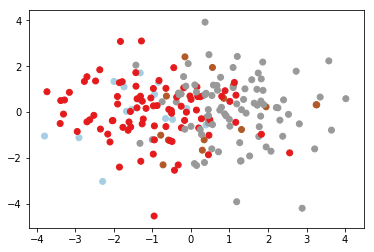

In [283]:
print X_toy.shape
plt.scatter(toy_test[:,0], toy_test[:,1], c=toy_y_test, cmap=plt.get_cmap('Paired') )
plt.scatter(toy_train[:,0], toy_train[:,1], c=toy_y_train, cmap=plt.get_cmap('Set1'))

In [306]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100)
lr.fit(sm_train, sm_y_train)
y_pred = lr.predict(sm_test)

print np.mean(sm_y_test.reshape(-1,) == sm_y_pred)

0.718


(784, 'dims')
(10, 'classes')
For hidden layer size:  20  result is: 
0.692
0.5
For hidden layer size:  100  result is: 
0.766
0.618
For hidden layer size:  500  result is: 
0.796
0.668
For hidden layer size:  800  result is: 
0.834
0.648
For hidden layer size:  1000  result is: 
0.834
0.674
For hidden layer size:  2000  result is: 
0.838
0.694
For hidden layer size:  3000  result is: 
0.858
0.716
For hidden layer size:  4000  result is: 
0.856
0.706
For hidden layer size:  5000  result is: 
0.846
0.728
For hidden layer size:  6000  result is: 
0.838
0.696
For hidden layer size:  7000  result is: 
0.848
0.71
For hidden layer size:  8000  result is: 
0.846
0.718
For hidden layer size:  9000  result is: 
0.85
0.696
For hidden layer size:  10000  result is: 
0.844
0.718


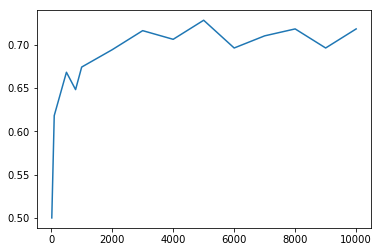

In [305]:
dims = sm_train.shape[1]
print(dims, 'dims')

sm_y_train_one_hot = keras.utils.to_categorical(sm_y_train)
nb_classes = sm_y_train_one_hot.shape[1]
print(nb_classes, 'classes')

sizes = [20, 100, 500, 800, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
results = []

for hidden_size in sizes:
    # 1. Definicja modelu

    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(dims, )))
    model.add(Dense(nb_classes, input_shape=(hidden_size, )))
    model.add(Activation('softmax'))

    # 2. Kompilacja
    model.compile(optimizer=SGD(lr=.01), loss='categorical_crossentropy')

    batch = 70

    # 3. Uczenie
    model.fit(sm_train, sm_y_train_one_hot, epochs=10, batch_size=batch, verbose=0)

    # 4. Predykcja
    sm_y_pred = model.predict(sm_test, batch_size=batch).argmax(axis=1)
    sm_y_train_pred = model.predict(sm_train, batch_size=batch).argmax(axis=1)
#     print model.layers[0].trainable_weights[0].get_value()
    print "For hidden layer size: ", hidden_size, " result is: "
    print np.mean(sm_y_train.reshape(-1,) == sm_y_train_pred)
    results.append(np.mean(sm_y_test.reshape(-1,) == sm_y_pred))
    print results[-1]
    
plt.plot(sizes, results)

# Inne sieci neuronowe

Najprostsze co możemy zrobić to dodać warstwy. Po co omówimy w następnym rozdziale.

<img width=600 src="figures/L9/zoo.jpg">

# Znaczenie reprezentacji, kNN

Najproszym argumentem po co te sieci jest możliwość uczenia się lepszych reprezentacji niż pixele, czy ręczne cechy w zbiorze danych breast cancer. Omówimy to na przykładzie zbiorów danych: iris i MNIST oraz klasyczngo modelu kNN.

Uruchomimy najpierw model kNN na danych iris

<img width=600 src="https://sebastianraschka.com/images/blog/2015/principal_component_analysis_files/iris.png">

In [319]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], test_size=0.15)

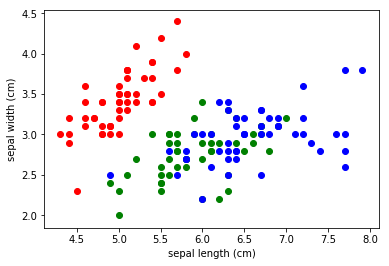

In [320]:
plt.scatter(iris.data[iris['target']==0, 0], iris.data[iris['target']==0, 1], color='r')
plt.scatter(iris.data[iris['target']==1, 0], iris.data[iris['target']==1, 1], color='g')
plt.scatter(iris.data[iris['target']==2, 0], iris.data[iris['target']==2, 1], color='b')
plt.xlabel(iris['feature_names'][0])
plt.ylabel(iris['feature_names'][1])

In [321]:
def knn_pred(x, x_train, y_train):
    current_best = -1, 100000
    for id in range(len(x_train)):
        dist = np.linalg.norm(x - x_train[id])
        if dist < current_best[1]:
            current_best = (id, dist)
    return y_train[current_best[0]]

## kNN na Iris

In [322]:
Y_test_pred = []
for x in tqdm.tqdm(X_test, total=len(X_test)):
    Y_test_pred.append(knn_pred(x, X_train, y_train))
print str(int(100*np.mean(np.array(Y_test_pred) == y_test))),"%"

100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1352.94it/s]


95 %


## small MNIST

Na Iris nasz prosty model osiąga 91%. Co sie dzieje na small MNIST?

In [323]:
Y_test_pred = []
for x in tqdm.tqdm(sm_test, total=len(sm_test)):
    Y_test_pred.append(knn_pred(x, x_train=sm_train, y_train=sm_y_train))
print str(int(100*np.mean(np.array(Y_test_pred) == sm_y_test))),"%"

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 343.17it/s]


79 %


## Co sie stalo

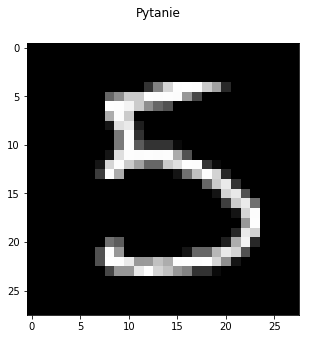

In [324]:
id_test = 15
plt.figure(figsize=(5, 5))
plt.suptitle("Pytanie")
plt.imshow(sm_test[id_test].reshape(28, 28), cmap=plt.cm.gray)

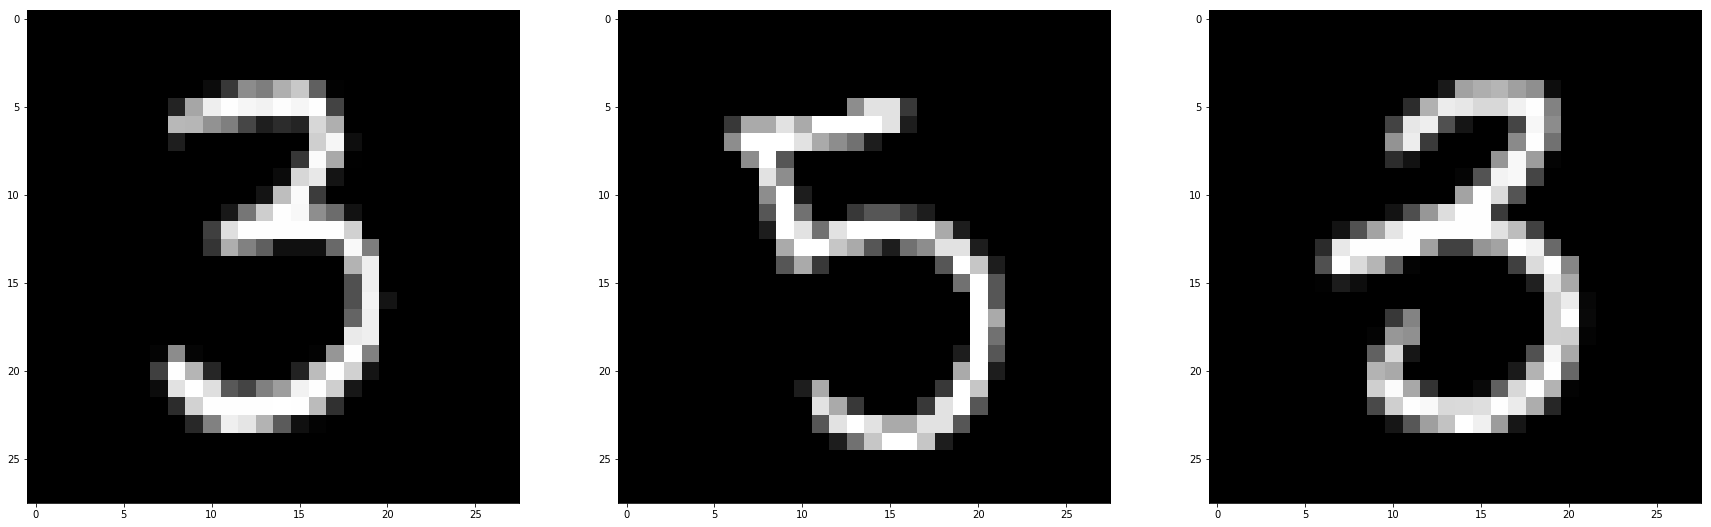

In [325]:
all_dists = [np.linalg.norm(sm_test[id_test].reshape(-1,) - x) for x in sm_train]
all_dists = np.argsort(all_dists)

f, ax = plt.subplots(1, 3, figsize=(30, 10))

for id, i in enumerate(all_dists[0:3]):
    ax[id].imshow(sm_train[all_dists[id]].reshape(28, 28), cmap=plt.cm.gray)

## Nauka reprezentacji

Ref: http://colah.github.io/posts/2014-10-Visualizing-MNIST/

Czlowiek uczy się reprezentacji - widzimy na poziomie krawędzi i kształtów, a nie pixeli!

<img width=500 src="figures/L9/cat_experiment_no_reference.png">

Zastanówmy się wspólnie jaka reprezentacja byłaby fajna? Główna idea Representation Learning, może będzie o tym więcej wkrótce:

<img width=600 src="figures/L9/autoencoder_schema.jpg">

### PCA

Na obecną chwilę użyjemy PCA, o którym prawdopodobnie będzie dużo więcej w przyszłości. 

<img src="figures/L9/pca.png">

(ilustracja pochodzi z tutorialu na temat PCA oraz ICA w sklearn, http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_vs_pca.html#sphx-glr-auto-examples-decomposition-plot-ica-vs-pca-py)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


[]

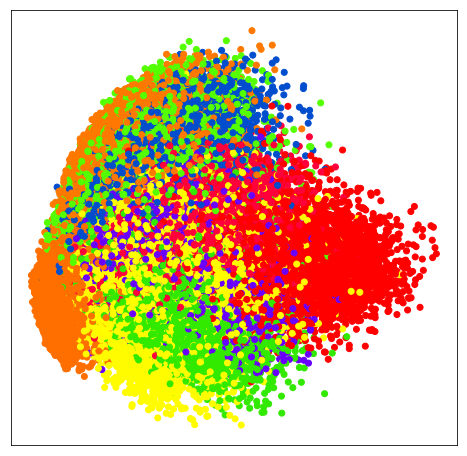

In [342]:
pca = RandomizedPCA(n_components=8, iterated_power=15, whiten=True)
fig, plot = plt.subplots()
fig.set_size_inches(8, 8)
plt.prism()

X_transformed = pca.fit_transform(mnist_x_train.reshape(mnist_x_train.shape[0], -1))
plot.scatter(X_transformed[:, 0], X_transformed[:, 1], c=mnist_y_train)
plot.set_xticks(())
plot.set_yticks(())

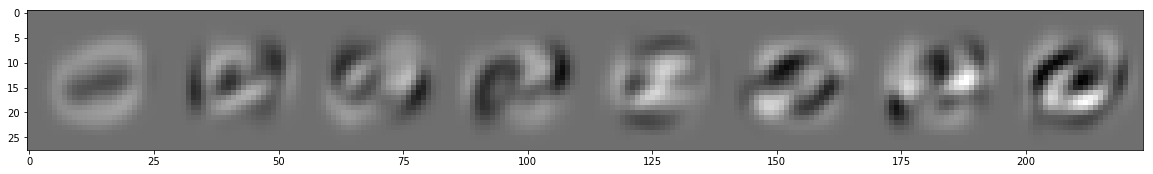

In [343]:
plt.figure(figsize=(20, 8 * 20))
plt.imshow(pca.components_.reshape((8 * 28, 28)).T, cmap="gray")

W przypadku twarzy PCA znajdzie bardzo ciekawy zestaw "cech", czy "wektorów bazowych":

<img width=400 src="figures/L9/eigenfaces.png">

## Zadanie 3, czy cechy pomagają w kNN [1pkt]

1. Naucz PCA jedynie na cyfrach 5 i załącz analogiczny plot jak powyżej

2. Użyj nauczonych cech (na całym zbiorze mnist) przez PCA do klasyfikacji kNN na zbiorze small MNIST. Jaki można osiągnąć wynik? Użyj KNeighborsClassifier z pakietu sklearn. Dopasuj parametry PCA oraz tak KNeighborsClassifier aby osiągnąć najlepszy wynik na zbiorze sm_test, wymagany jest wynik powyżej 80% na zbiorze testowym.

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


(5421, 28, 28)


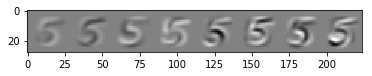

In [352]:
fives = mnist_x_train[mnist_y_train==5]

pca = RandomizedPCA(n_components=8, iterated_power=15, whiten=True)

X_transformed = pca.fit_transform(fives.reshape(fives.shape[0], -1))

plt.imshow(np.concatenate(pca.components_.reshape((8, 28, 28)), axis=1), cmap="gray")

In [12]:
from sklearn.neighbors import KNeighborsClassifier

for n_comp in [5, 10, 15, 30, 50]:
    
    pca = RandomizedPCA(n_components=n_comp, iterated_power=15, whiten=True)
    print "trainging new pca: ", n_comp
    train_pca = pca.fit_transform(mnist_x_train.reshape(mnist_x_train.shape[0], -1))
    
    sm_test_pca = pca.transform(sm_test)
    sm_train_pca = pca.transform(sm_train)

    for weights in ['distance', 'uniform']:
        for algorithm in ['ball_tree', 'kd_tree', 'brute']:
            for p in [1.0, 1.2, 1.5, 1.7, 2.0]:
                for n in [3, 5, 10, 15, 30, 50]:
                    knn = KNeighborsClassifier(weights=weights, algorithm=algorithm, p=p, n_neighbors=n)

    #                 knn.fit(train_pca, mnist_y_train )
                    knn.fit(sm_train_pca, sm_y_train)
                    y_test_pred = knn.predict(sm_test_pca)
                    print n_comp, ",", weights, ",", algorithm, ",", p, ",", n, ":", 
                    print str(int(100*np.mean(np.array(y_test_pred) == sm_y_test))),"%  "

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


trainging new pca:  5
5 , distance , ball_tree , 1.0 , 3 : 58 %  
5 , distance , ball_tree , 1.0 , 5 : 60 %  
5 , distance , ball_tree , 1.0 , 10 : 60 %  
5 , distance , ball_tree , 1.0 , 15 : 58 %  
5 , distance , ball_tree , 1.0 , 30 : 57 %  
5 , distance , ball_tree , 1.0 , 50 : 56 %  
5 , distance , ball_tree , 1.2 , 3 : 59 %  
5 , distance , ball_tree , 1.2 , 5 : 60 %  
5 , distance , ball_tree , 1.2 , 10 : 61 %  
5 , distance , ball_tree , 1.2 , 15 : 59 %  
5 , distance , ball_tree , 1.2 , 30 : 58 %  
5 , distance , ball_tree , 1.2 , 50 : 56 %  
5 , distance , ball_tree , 1.5 , 3 : 58 %  
5 , distance , ball_tree , 1.5 , 5 : 60 %  
5 , distance , ball_tree , 1.5 , 10 : 62 %  
5 , distance , ball_tree , 1.5 , 15 : 59 %  
5 , distance , ball_tree , 1.5 , 30 : 60 %  
5 , distance , ball_tree , 1.5 , 50 : 57 %  
5 , distance , ball_tree , 1.7 , 3 : 57 %  
5 , distance , ball_tree , 1.7 , 5 : 61 %  
5 , distance , ball_tree , 1.7 , 10 : 62 %  
5 , distance , ball_tree , 1.7 , 15 : 60 

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


trainging new pca:  10
10 , distance , ball_tree , 1.0 , 3 : 75 %  
10 , distance , ball_tree , 1.0 , 5 : 77 %  
10 , distance , ball_tree , 1.0 , 10 : 76 %  
10 , distance , ball_tree , 1.0 , 15 : 73 %  
10 , distance , ball_tree , 1.0 , 30 : 70 %  
10 , distance , ball_tree , 1.0 , 50 : 68 %  
10 , distance , ball_tree , 1.2 , 3 : 75 %  
10 , distance , ball_tree , 1.2 , 5 : 77 %  
10 , distance , ball_tree , 1.2 , 10 : 75 %  
10 , distance , ball_tree , 1.2 , 15 : 74 %  
10 , distance , ball_tree , 1.2 , 30 : 71 %  
10 , distance , ball_tree , 1.2 , 50 : 68 %  
10 , distance , ball_tree , 1.5 , 3 : 76 %  
10 , distance , ball_tree , 1.5 , 5 : 78 %  
10 , distance , ball_tree , 1.5 , 10 : 76 %  
10 , distance , ball_tree , 1.5 , 15 : 75 %  
10 , distance , ball_tree , 1.5 , 30 : 70 %  
10 , distance , ball_tree , 1.5 , 50 : 66 %  
10 , distance , ball_tree , 1.7 , 3 : 76 %  
10 , distance , ball_tree , 1.7 , 5 : 79 %  
10 , distance , ball_tree , 1.7 , 10 : 76 %  
10 , distance , bal

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


trainging new pca:  15
15 , distance , ball_tree , 1.0 , 3 : 76 %  
15 , distance , ball_tree , 1.0 , 5 : 78 %  
15 , distance , ball_tree , 1.0 , 10 : 78 %  
15 , distance , ball_tree , 1.0 , 15 : 76 %  
15 , distance , ball_tree , 1.0 , 30 : 73 %  
15 , distance , ball_tree , 1.0 , 50 : 68 %  
15 , distance , ball_tree , 1.2 , 3 : 77 %  
15 , distance , ball_tree , 1.2 , 5 : 78 %  
15 , distance , ball_tree , 1.2 , 10 : 77 %  
15 , distance , ball_tree , 1.2 , 15 : 76 %  
15 , distance , ball_tree , 1.2 , 30 : 73 %  
15 , distance , ball_tree , 1.2 , 50 : 69 %  
15 , distance , ball_tree , 1.5 , 3 : 77 %  
15 , distance , ball_tree , 1.5 , 5 : 78 %  
15 , distance , ball_tree , 1.5 , 10 : 79 %  
15 , distance , ball_tree , 1.5 , 15 : 76 %  
15 , distance , ball_tree , 1.5 , 30 : 71 %  
15 , distance , ball_tree , 1.5 , 50 : 67 %  
15 , distance , ball_tree , 1.7 , 3 : 78 %  
15 , distance , ball_tree , 1.7 , 5 : 79 %  
15 , distance , ball_tree , 1.7 , 10 : 79 %  
15 , distance , bal

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


trainging new pca:  30
30 , distance , ball_tree , 1.0 , 3 : 79 %  
30 , distance , ball_tree , 1.0 , 5 : 78 %  
30 , distance , ball_tree , 1.0 , 10 : 76 %  
30 , distance , ball_tree , 1.0 , 15 : 72 %  
30 , distance , ball_tree , 1.0 , 30 : 65 %  
30 , distance , ball_tree , 1.0 , 50 : 58 %  
30 , distance , ball_tree , 1.2 , 3 : 80 %  
30 , distance , ball_tree , 1.2 , 5 : 79 %  
30 , distance , ball_tree , 1.2 , 10 : 76 %  
30 , distance , ball_tree , 1.2 , 15 : 72 %  
30 , distance , ball_tree , 1.2 , 30 : 64 %  
30 , distance , ball_tree , 1.2 , 50 : 59 %  
30 , distance , ball_tree , 1.5 , 3 : 80 %  
30 , distance , ball_tree , 1.5 , 5 : 79 %  
30 , distance , ball_tree , 1.5 , 10 : 77 %  
30 , distance , ball_tree , 1.5 , 15 : 72 %  
30 , distance , ball_tree , 1.5 , 30 : 65 %  
30 , distance , ball_tree , 1.5 , 50 : 58 %  
30 , distance , ball_tree , 1.7 , 3 : 81 %  
30 , distance , ball_tree , 1.7 , 5 : 80 %  
30 , distance , ball_tree , 1.7 , 10 : 76 %  
30 , distance , bal

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


trainging new pca:  50
50 , distance , ball_tree , 1.0 , 3 : 71 %  
50 , distance , ball_tree , 1.0 , 5 : 70 %  
50 , distance , ball_tree , 1.0 , 10 : 63 %  
50 , distance , ball_tree , 1.0 , 15 : 57 %  
50 , distance , ball_tree , 1.0 , 30 : 45 %  
50 , distance , ball_tree , 1.0 , 50 : 32 %  
50 , distance , ball_tree , 1.2 , 3 : 72 %  
50 , distance , ball_tree , 1.2 , 5 : 71 %  
50 , distance , ball_tree , 1.2 , 10 : 62 %  
50 , distance , ball_tree , 1.2 , 15 : 57 %  
50 , distance , ball_tree , 1.2 , 30 : 46 %  
50 , distance , ball_tree , 1.2 , 50 : 32 %  
50 , distance , ball_tree , 1.5 , 3 : 71 %  
50 , distance , ball_tree , 1.5 , 5 : 71 %  
50 , distance , ball_tree , 1.5 , 10 : 63 %  
50 , distance , ball_tree , 1.5 , 15 : 58 %  
50 , distance , ball_tree , 1.5 , 30 : 46 %  
50 , distance , ball_tree , 1.5 , 50 : 31 %  
50 , distance , ball_tree , 1.7 , 3 : 72 %  
50 , distance , ball_tree , 1.7 , 5 : 70 %  
50 , distance , ball_tree , 1.7 , 10 : 63 %  
50 , distance , bal

Np: <br>
... <br>
30 , distance , brute , 1.7 , 3 : 81 % <br>
... <br>